In [4]:
import calendar
import requests
import pandas as pd
import holidays
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from src.config import EPIAS_USERNAME, EPIAS_PASSWORD

In [ ]:
# 2022-2025 consumption data from EPIAS

USERNAME = EPIAS_USERNAME
PASSWORD = EPIAS_PASSWORD

# TGT
response_cas = requests.post(
    "https://giris.epias.com.tr/cas/v1/tickets",
    data={'username': USERNAME, 'password': PASSWORD}
)

tgt = response_cas.headers['Location'].split('/')[-1]

# data
all_data = []

for year in range(2022, 2026):
    for month in range(1, 13):
        last_day = calendar.monthrange(year, month)[1]
        
        start_str = f"{year}-{month:02d}-01T00:00:00+03:00"
        end_str =   f"{year}-{month:02d}-{last_day}T23:59:59+03:00"
        
        print(f"{year}-{month:02d}.", end="")
    
        resp = requests.post(
            "https://seffaflik.epias.com.tr/electricity-service/v1/consumption/data/realtime-consumption",
            headers={'TGT': tgt, 'Content-Type': 'application/json'},
            json={"startDate": start_str, "endDate": end_str}
        )
        
        if resp.status_code == 200:
            items = resp.json().get('items', [])
            all_data.extend(items)
            print(f" OK. ({len(items)} lines)")
        else:
            print(f" error: {resp.status_code}")

df=pd.DataFrame(all_data)
df.drop(columns=["time"], inplace=True)
df.to_csv("epias_data_2022-2025.csv", index=False)

In [ ]:
# 2025 consumption predictions from EPIAS for comparison with our model

comp=[]
for month in range(1, 13):
    last_day = calendar.monthrange(2025, month)[1]
    
    start_str = f"{2025}-{month:02d}-01T00:00:00+03:00"
    end_str =   f"{2025}-{month:02d}-{last_day}T00:59:59+03:00"
    
    print(f"{2025}-{month:02d}.", end="")

    resp = requests.post(
        "https://seffaflik.epias.com.tr/electricity-service/v1/consumption/data/load-estimation-plan",
        headers={'TGT': tgt, 'Content-Type': 'application/json'},
        json={"startDate": start_str, "endDate": end_str}
    )
    
    if resp.status_code == 200:
        items = resp.json().get('items', [])
        comp.extend(items)
        print(f" OK. ({len(items)} lines)")
    else:
        print(f" error: {resp.status_code}")

comparison_df=pd.DataFrame(comp)
comparison_df.drop(columns=["time"], inplace=True)
comparison_df["date"] = pd.to_datetime(comparison_df["date"], utc=True).dt.tz_convert("Europe/Istanbul")
comparison_df.rename(columns={"lep": "prediction"}, inplace=True)
comparison_df.to_csv("epias_2025_comparison.csv", index=False)

In [22]:
df= pd.read_csv("epias_data_2022-2025.csv")
comparison_df = pd.read_csv("epias_2025_comparison.csv")

df["date"] = pd.to_datetime(df["date"], utc=True).dt.tz_convert("Europe/Istanbul")
comparison_df["date"] = pd.to_datetime(comparison_df["date"], utc=True).dt.tz_convert("Europe/Istanbul")

In [ ]:
# holidays

tr_holidays = holidays.Turkey(years=range(2022, 2026))
holiday_dates = set(tr_holidays.keys())
df['is_holiday'] = df['date'].dt.date.isin(holiday_dates)
df['is_holiday'] = df['is_holiday'].astype(int)


In [24]:
# weather forecast from one day before from Open-Meteo

start_date_str = df["date"].min().strftime("%Y-%m-%d")
end_date_str = date.today().strftime("%Y-%m-%d")

url = "https://historical-forecast-api.open-meteo.com/v1/forecast"

params = {
    "latitude": 39.0,
    "longitude": 35.0,
    "start_date": start_date_str,
    "end_date": end_date_str,
    "hourly": "temperature_2m",
    "models": "gfs_seamless",
    "timezone": "Europe/Istanbul"
}

r = requests.get(url, params=params, timeout=30)
r.raise_for_status()
data = r.json()

hourly_data = data["hourly"]

forecast_df = pd.DataFrame({
    "date": hourly_data["time"],
    "forecast_temp": hourly_data["temperature_2m"]
})

forecast_df["date"] = pd.to_datetime(forecast_df["date"])

forecast_df["date"] = forecast_df["date"].dt.tz_localize("Europe/Istanbul", ambiguous='NaT', nonexistent='shift_forward')

df = pd.merge(df, forecast_df, on="date", how="left")


In [25]:
# add is_ramadan and is_kurban

RAMADAN_DATES = [
    ("2022-04-02", "2022-05-01"),
    ("2023-03-23", "2023-04-20"),
    ("2024-03-11", "2024-04-09"),
    ("2025-03-01", "2025-03-29"),
    ("2026-02-18", "2026-03-19"),
    ("2027-02-08", "2027-03-08"),
]

KURBAN_DATES = [
    ("2022-07-09", "2022-07-12"),
    ("2023-06-28", "2023-07-01"),
    ("2024-06-17", "2024-06-20"),
    ("2025-06-06", "2025-06-09"),
    ("2026-05-26", "2026-05-29"),
    ("2027-05-16", "2027-05-19"),
]

ramadan_set = set()
for start, end in RAMADAN_DATES:
    for d in pd.date_range(start, end):
        ramadan_set.add(d.date())

kurban_set = set()
for start, end in KURBAN_DATES:
    for d in pd.date_range(start, end):
        kurban_set.add(d.date())

dates = pd.to_datetime(df['date']).dt.date

df['is_ramadan'] = [1 if d in ramadan_set else 0 for d in dates]
df['is_kurban'] = [1 if d in kurban_set else 0 for d in dates]


In [26]:
df

,date,consumption,is_holiday,forecast_temp,is_ramadan,is_kurban
0,2022-01-01 00:00:00+03:00,31021.25,1,1.4,0,0
1,2022-01-01 01:00:00+03:00,29710.69,1,1.4,0,0
2,2022-01-01 02:00:00+03:00,28318.53,1,1.1,0,0
3,2022-01-01 03:00:00+03:00,27169.55,1,1.0,0,0
4,2022-01-01 04:00:00+03:00,26525.16,1,1.0,0,0
...,...,...,...,...,...,...
35059,2025-12-31 19:00:00+03:00,42962.65,0,0.0,0,0
35060,2025-12-31 20:00:00+03:00,40748.00,0,-0.4,0,0
35061,2025-12-31 21:00:00+03:00,38865.29,0,-1.1,0,0
35062,2025-12-31 22:00:00+03:00,37450.71,0,-2.3,0,0


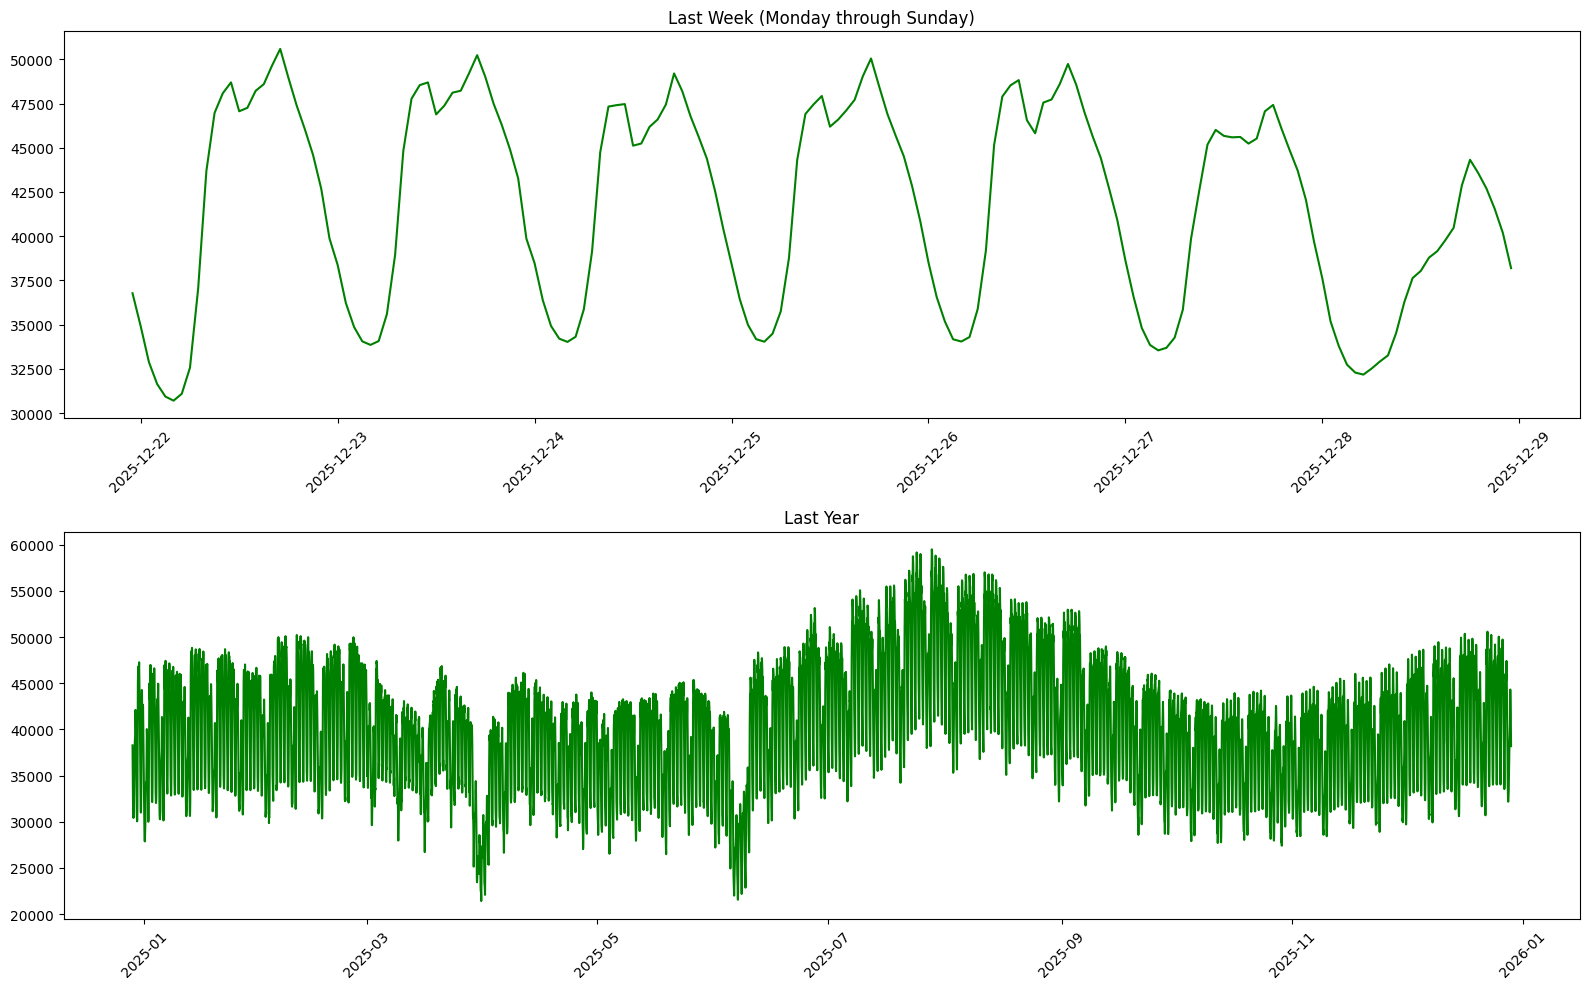

In [27]:
# weekly and yearly windows for visualization

last_day = df['date'].max() - pd.Timedelta(days=3)

windows = {
    "Last Week (Monday through Sunday)": last_day - pd.Timedelta(days=7),
    "Last Year": last_day - pd.Timedelta(days=365),
}

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes = axes.flatten()

for ax, (title, start_date) in zip(axes, windows.items()):
    subset = df[(df['date'] >= start_date) & (df['date'] <= last_day)]
    ax.plot(subset['date'], subset['consumption'], color ="green")
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df = df.set_index('date')

# Temporal features
df['hour'] = df.index.hour
df['dayofyear'] = df.index.dayofyear
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year

df['temp_squared'] = df['forecast_temp'] ** 2

'''
Lag Construction for Day-Ahead with EPIAS Logic:
Predict Day D+1 at 12:30 on Day D.
We cannot use Lag 24 because late hours of Day D are unknown at 12:30.
Most recent available full-day lag is 48 hours (Data from D-1).
'''
df['lag_48'] = df['consumption'].shift(48)
df['lag_72'] = df['consumption'].shift(72)
df['lag_168'] = df['consumption'].shift(168)

# Rolling statistics based on available data (Lag 48)
df['roll_mean_1d'] = df['lag_48'].rolling(window=24).mean()
df['roll_std_1d'] = df['lag_48'].rolling(window=24).std()

df['roll_mean_1w'] = df['lag_48'].rolling(window=168).mean()
df['roll_std_1w'] = df['lag_48'].rolling(window=168).std()


# Drop rows with NaN values created by lags
df_model = df.dropna()

df_model

,consumption,is_holiday,forecast_temp,is_ramadan,is_kurban,hour,dayofyear,dayofweek,month,quarter,year,temp_squared,lag_48,lag_72,lag_168,roll_mean_1d,roll_std_1d,roll_mean_1w,roll_std_1w
date,,,,,,,,,,,,,,,,,,,
2022-01-09 23:00:00+03:00,34312.71,0,2.5,0,0,23,9,6,1,1,2022,6.25,37475.66,37319.25,33986.99,38968.873750,4620.326035,36940.389881,5581.791550
2022-01-10 00:00:00+03:00,32456.36,0,3.6,0,0,0,10,0,1,1,2022,12.96,35324.41,35160.98,32072.88,38975.683333,4614.586701,36966.003929,5564.312740
2022-01-10 01:00:00+03:00,30796.73,0,3.7,0,0,1,10,0,1,1,2022,13.69,33565.47,33453.96,30325.87,38980.329583,4608.837925,36988.949048,5542.118987
2022-01-10 02:00:00+03:00,29950.11,0,4.0,0,0,2,10,0,1,1,2022,16.00,32455.37,32302.25,29104.46,38986.709583,4599.287634,37013.573095,5512.475859
2022-01-10 03:00:00+03:00,29359.42,0,3.6,0,0,3,10,0,1,1,2022,12.96,31631.25,31678.85,28572.01,38984.726250,4602.585071,37040.130833,5475.388737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 19:00:00+03:00,42962.65,0,0.0,0,0,19,365,2,12,4,2025,0.00,48107.05,43565.49,46781.59,42282.047500,7039.787785,41910.157262,5735.932098
2025-12-31 20:00:00+03:00,40748.00,0,-0.4,0,0,20,365,2,12,4,2025,0.16,46985.13,42694.49,45611.05,42460.824167,7104.896925,41915.739464,5740.437058
2025-12-31 21:00:00+03:00,38865.29,0,-1.1,0,0,21,365,2,12,4,2025,1.21,45573.84,41551.86,44375.16,42628.406667,7129.914096,41921.591548,5743.680582


In [ ]:
# train test val splits

train = df_model.loc[df_model.index < '2024-01-01']
val = df_model.loc[(df_model.index >= '2024-01-01') & (df_model.index < '2025-01-01')]
test = df_model.loc[df_model.index >= '2025-01-01']

features = ['hour', 'dayofweek', 'dayofyear', 'month', 'year', 'is_holiday', 'is_ramadan', 'is_kurban', 'forecast_temp', 
            'temp_squared', 'lag_48', 'lag_72', 'lag_168', 'roll_mean_1d', 'roll_std_1d', 'roll_mean_1w', 'roll_std_1w']
target = 'consumption'

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (17305, 17), Val shape: (8784, 17), Test shape: (8760, 17)


In [30]:
# Training the model with early stopping on the validation set and getting the best iteration

model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

preds = model.predict(X_test)

print(f"Best iteration: {model.best_iteration}")

mae = mean_absolute_error(y_test, preds)
rmse = root_mean_squared_error(y_test, preds)
print(f"\nInitial test RMSE: {rmse:.2f}")
print(f"Initial test MAE: {mae:.2f}")


Best iteration: 271

Initial test RMSE: 2029.40
Initial test MAE: 1483.39


In [ ]:
# training on 2022-2024 data and evaluation on 2025 test set

X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

final_model = xgb.XGBRegressor(
    n_estimators=model.best_iteration + 50,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1
)

final_model.fit(X_train_full, y_train_full)

preds_full = final_model.predict(X_test)

mae_full = mean_absolute_error(y_test, preds_full)
rmse_full = root_mean_squared_error(y_test, preds_full)
print(f"Final Test RMSE: {rmse_full:.2f}")
print(f"Final Test MAE: {mae_full:.2f}")


Final Test RMSE: 1550.60
Final Test MAE: 1100.18


In [32]:
# mae and rmse for EPIAS predictions

comparison_df.set_index('date', inplace=True)
y_test_indexed = y_test.to_frame().set_index(comparison_df.index)
comparison_df['prediction'] = comparison_df['prediction'].astype(float)
comparison_df['y_test'] = y_test_indexed['consumption']
comparison_mae = mean_absolute_error(comparison_df['y_test'], comparison_df['prediction'])
comparison_rmse = root_mean_squared_error(comparison_df['y_test'], comparison_df['prediction'])
print(f"EPIAS Prediction RMSE: {comparison_rmse:.2f}")
print(f"EPIAS Prediction MAE: {comparison_mae:.2f}")

EPIAS Prediction RMSE: 1863.16
EPIAS Prediction MAE: 1236.55


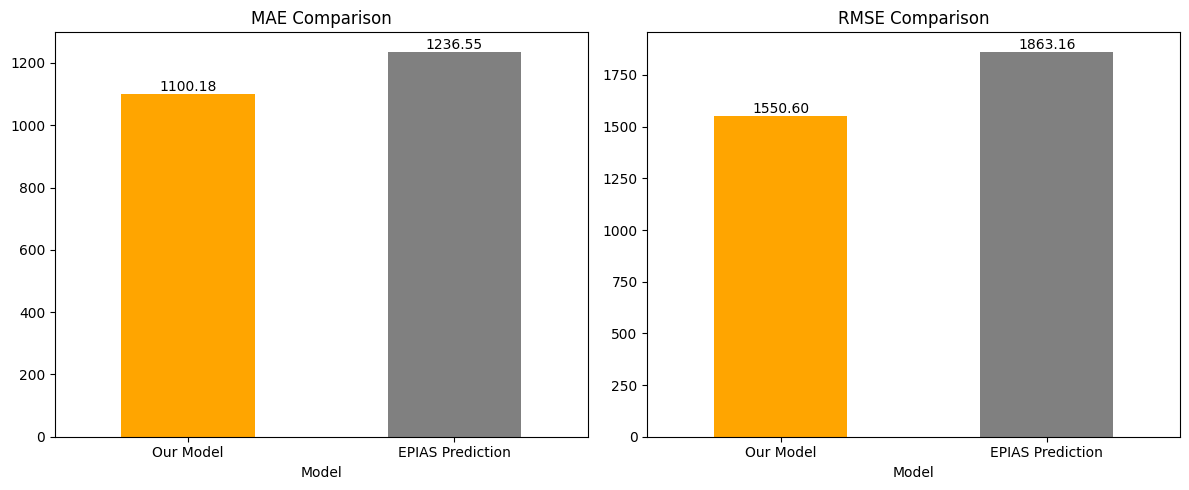

In [33]:
# our model vs EPIAS predictions
results_df = pd.DataFrame({
    'Model': ['Our Model', 'EPIAS Prediction'],
    'MAE': [mae_full, comparison_mae],
    'RMSE': [rmse_full, comparison_rmse]
})

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

results_df.plot(x='Model', y='MAE', kind='bar', ax=ax[0], color=['orange', 'gray'], legend=False)
ax[0].set_xticklabels(results_df['Model'], rotation=0)
ax[0].set_title('MAE Comparison')
for i, (idx, row) in enumerate(results_df.iterrows()):
    ax[0].text(i, row['MAE'] + 0.1, f"{row['MAE']:.2f}", ha='center', va='bottom')

results_df.plot(x='Model', y='RMSE', kind='bar', ax=ax[1], color=['orange', 'gray'], legend=False)
ax[1].set_xticklabels(results_df['Model'], rotation=0)
ax[1].set_title('RMSE Comparison')
for i, (idx, row) in enumerate(results_df.iterrows()):
    ax[1].text(i, row['RMSE'] + 0.1, f"{row['RMSE']:.2f}", ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

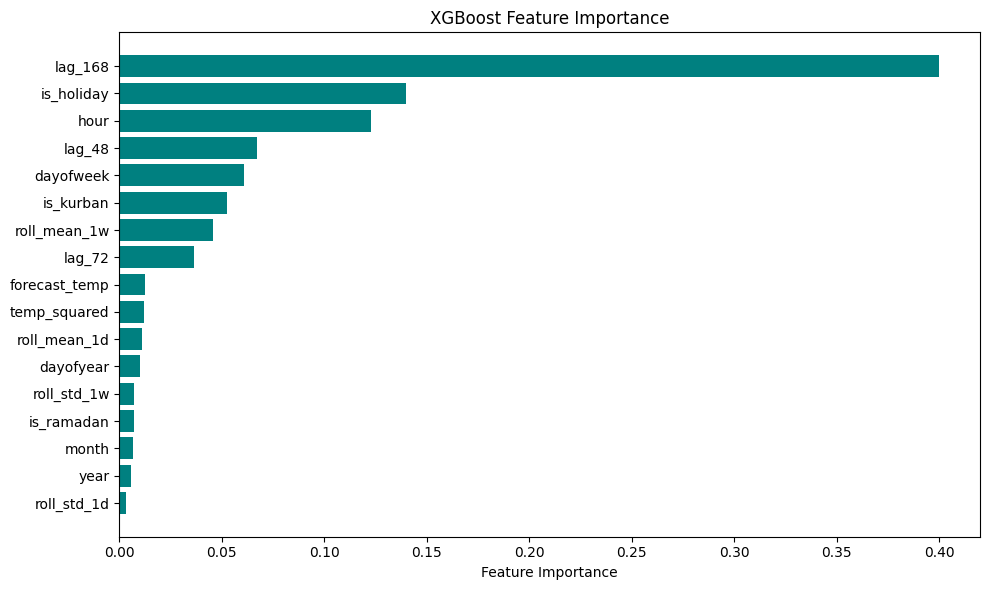

In [34]:
# xgboost feature importance

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

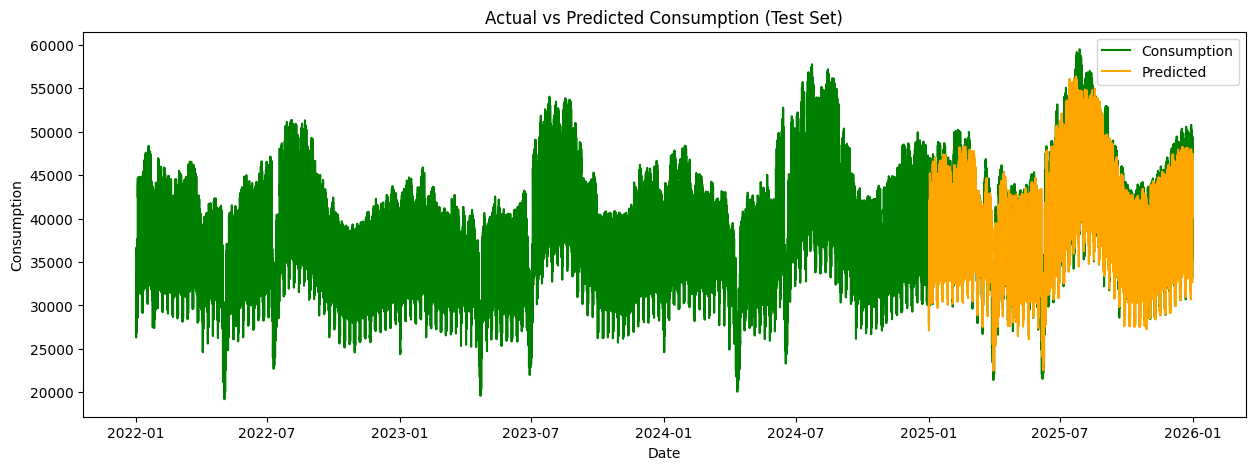

In [35]:
# actual vs predicted

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['consumption'], label='Consumption', color='green')
plt.plot(test.index, preds_full, label='Predicted', color='orange')
plt.title('Actual vs Predicted Consumption (Test Set)')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()

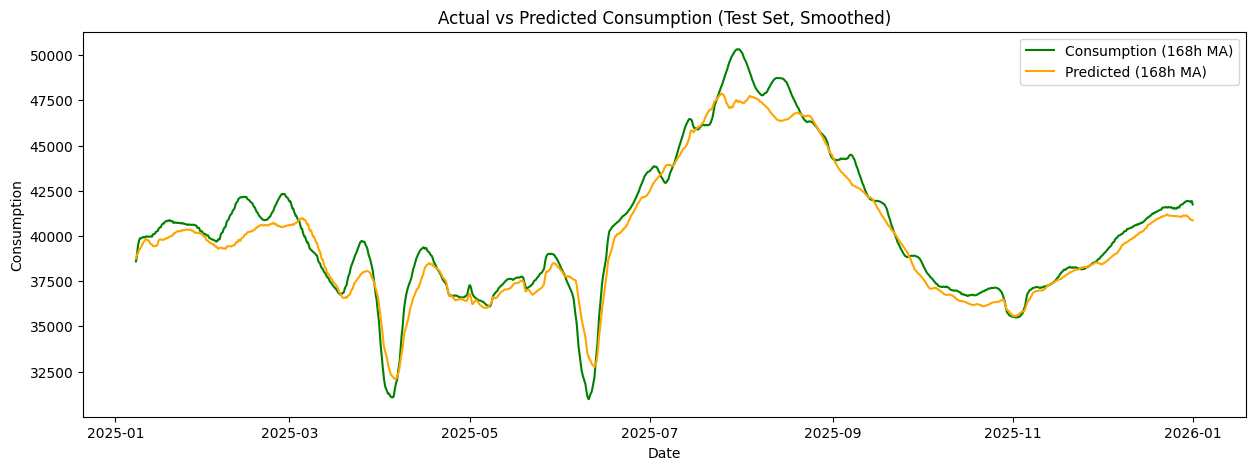

In [36]:
# actual vs predicted for test set (smoothed)

plt.figure(figsize=(15, 5))
plt.plot(test.index, pd.Series(y_test).rolling(window=168).mean(), label='Consumption (168h MA)', color='green')
plt.plot(test.index, pd.Series(preds_full).rolling(window=168).mean(), label='Predicted (168h MA)', color='orange')
plt.title('Actual vs Predicted Consumption (Test Set, Smoothed)')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()

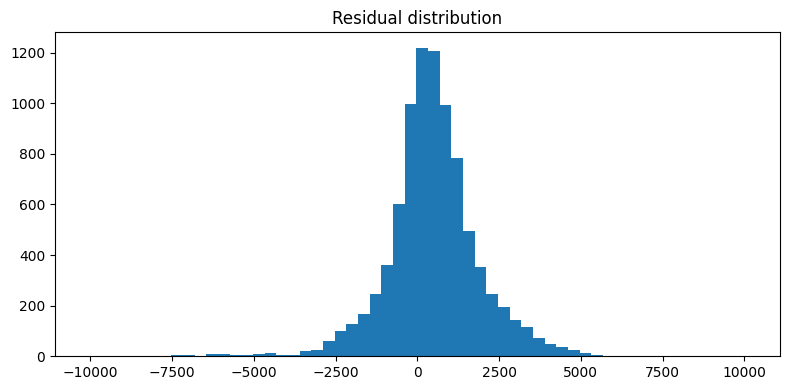

In [37]:
# Residual distribution

resid = (y_test - preds_full)
plt.figure(figsize=(8, 4))
plt.hist(resid.values, bins=50)
max_abs = np.abs(resid.values).max()
plt.xlim(-max_abs, max_abs)
plt.title('Residual distribution')
plt.tight_layout()
plt.show()

In [ ]:
# getting best n estimators for production model with 22-24 train, 25 val

X_train_prod = pd.concat([X_train, X_val])
y_train_prod = pd.concat([y_train, y_val])

prod_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1
)

prod_model.fit(
    X_train_prod, y_train_prod,
    eval_set=[(X_test, y_test)],
    verbose=200
)


[0]	validation_0-rmse:6883.58711
[200]	validation_0-rmse:1562.37116
[400]	validation_0-rmse:1547.68404
[600]	validation_0-rmse:1547.30978
[800]	validation_0-rmse:1546.60089
[1000]	validation_0-rmse:1548.79980
[1200]	validation_0-rmse:1548.70467
[1400]	validation_0-rmse:1550.10077
[1600]	validation_0-rmse:1551.37191
[1800]	validation_0-rmse:1552.67027
[1999]	validation_0-rmse:1553.72002


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 